# Labs

## 0. Load libraries

### WARNING!

Install local robin module: `python3 -m pip install -e /Users/david/PycharmProjects/robin`

In [1]:
%load_ext autoreload
%autoreload 2

import cProfile as profile
import json
import numpy as np
import pandas as pd
import pprint
import time
import yaml

from benchmarks.generator import get_revenue_behaviour, get_revenue_behaviour_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, TrainSchedulePlotter, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution

from robin.kernel.entities import Kernel
from robin.plotter.entities import KernelPlotter
from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from pathlib import Path
from tqdm.notebook import tqdm
from typing import Any, List, Mapping, Tuple, Union
import shutil

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/gsa_results/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

if Path(robin_save_path).exists():
    shutil.rmtree(robin_save_path)
    
Path(robin_save_path).mkdir(parents=True)

if Path(figures).exists():
    shutil.rmtree(figures)

Path(figures).mkdir(parents=True)

In [3]:
seed = 21

if generator_config_path:
    n_services = int_input("Number of services to generate: ")
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 75


In [4]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

       Number of Services
RU2                    13
RU3                    29
RU1                    18
RU4                    15
Total                  75


In [5]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behaviour = get_revenue_behaviour_deprecated(supply)
lines = supply.lines
line = infer_line_stations(lines)

#plotter = TrainSchedulePlotter(requested_schedule, line)
#plotter.plot(main_title="Peticiones RUs (25)", save_path=Path('../figures/requested_schedule.pdf'))

Services:  75


{'0_2024-06-25-17.40': {'Zaragoza': [1060.0, 1061.0], 'Lleida': [1107.0, 1109.0], 'Tarragona': [1138.0, 1140.0], 'Barcelona': [1179.0, 1179.0]}, '1_2024-06-25-14.32': {'Madrid': [872.0, 872.0], 'Zaragoza': [969.0, 970.0], 'Tarragona': [1042.0, 1044.0], 'Barcelona': [1094.0, 1094.0]}, '2_2024-06-25-15.04': {'Madrid': [904.0, 904.0], 'Barcelona': [1066.0, 1066.0]}, '3_2024-06-25-13.47': {'Madrid': [827.0, 827.0], 'Zaragoza': [911.0, 912.0], 'Barcelona': [1012.0, 1012.0]}, '4_2024-06-25-22.34': {'Madrid': [1354.0, 1354.0], 'Barcelona': [1522.0, 1522.0]}, '5_2024-06-25-12.09': {'Lleida': [729.0, 731.0], 'Barcelona': [802.0, 802.0]}, '6_2024-06-25-2.10': {'Madrid': [130.0, 130.0], 'Zaragoza': [209.0, 210.0], 'Tarragona': [269.0, 271.0], 'Barcelona': [311.0, 311.0]}, '7_2024-06-25-8.02': {'Madrid': [482.0, 482.0], 'Barcelona': [662.0, 662.0]}, '8_2024-06-25-8.51': {'Madrid': [531.0, 531.0], 'Zaragoza': [629.0, 630.0], 'Lleida': [689.0, 692.0], 'Barcelona': [781.0, 781.0]}, '9_2024-06-25-15.2

/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


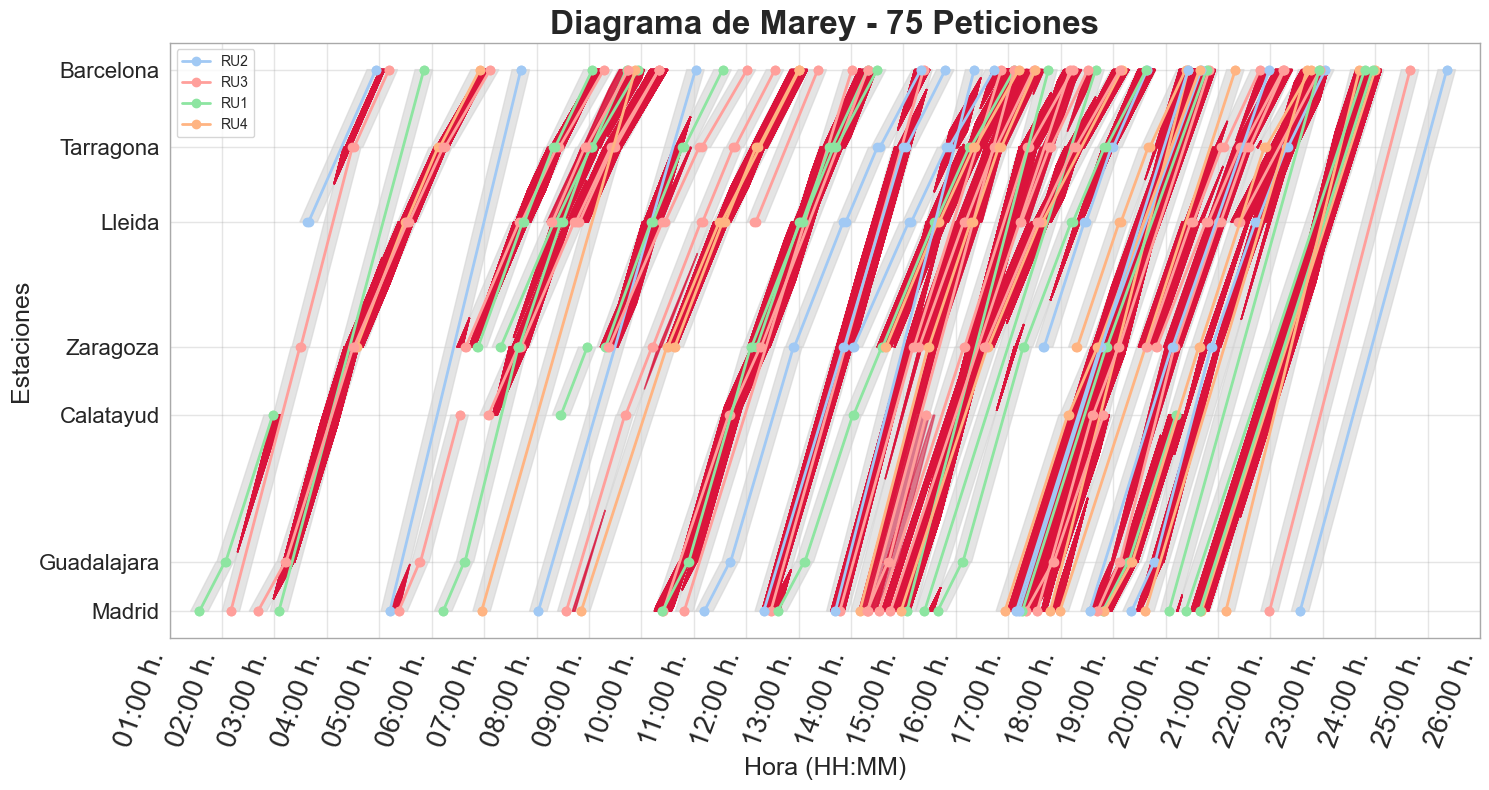

In [6]:
plot_marey_chart(requested_supply=supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey - 75 Peticiones",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/gsa/marey_chart_requests_75.pdf'))

In [7]:
#pr = profile.Profile()
#pr.enable()
import random

def run_gsa(chaotic_constant: bool=False,
            runs: int=10,
            population_size: int=20,
            iters: int=50,
            global_seed: int=21
            ) -> Tuple[pd.DataFrame, pd.DataFrame, Any]:
    random.seed(global_seed)
    
    runs_best_solution_history = {}
    
    global_train_hist = pd.DataFrame()
    global_population_hist = pd.DataFrame()
    
    for r in range(1, runs + 1):
        print(f"Run {r}")
        sm = RevenueMaximization(requested_schedule=requested_schedule,
                                 revenue_behaviour=revenue_behaviour,
                                 line=line,
                                 safe_headway=10)
    
        gsa_algo = GSA(objective_function=sm.get_fitness_gsa,
                       is_feasible=sm.feasible_services_times,
                       custom_repair=sm.custom_repair,
                       r_dim=len(sm.boundaries.real),
                       d_dim=0,
                       boundaries=sm.boundaries)
        
        gsa_algo.set_seed(seed=random.randint(0, 1000))
        training_history = gsa_algo.optimize(population_size=population_size,
                                             iters=iters,
                                             chaotic_constant=chaotic_constant,
                                             repair_solution=True,
                                             initial_population=sm.get_initial_population(population),
                                             verbose=verbosity,
                                             save_population=True)
    
        training_history.insert(0, "Run", r)
        training_history['Discrete'] = [sm.get_heuristic_schedule(Solution(real=r, discrete=np.array([]))) for r in training_history['Real']]
        global_train_hist = pd.concat([global_train_hist, training_history], axis=0)
        
        gsa_algo.population_history.insert(0, "Run", r)
        global_population_hist = pd.concat([global_population_hist, gsa_algo.population_history], axis=0)
    
        runs_best_solution_history[r] = (sm.best_solution, sm.best_revenue)
        
    return global_train_hist, global_population_hist, runs_best_solution_history
        
#pr.disable()
#pr.dump_stats('profile.pstat')

## 1. Chaotic vs Normal GSA

In [8]:
runs = 11
population = 20
iters = 50
verbosity = False
rbs_hist = {}

df_gcc = pd.DataFrame()
df_gpp = pd.DataFrame()
for chaotic_constant in [True, False]:
    print(f"Running GSA with chaotic constant: ", chaotic_constant)
    df_train, df_pop, rbs_hist[chaotic_constant] = run_gsa(chaotic_constant=chaotic_constant,
                                                           runs=runs,
                                                           population_size=population,
                                                           iters=iters)
    
    df_train["chaotic_constant"] = chaotic_constant
    df_gcc = pd.concat([df_gcc, df_train], axis=0)
    
    df_pop["chaotic_constant"] = chaotic_constant
    df_gpp = pd.concat([df_gpp, df_pop], axis=0)

Running GSA with chaotic constant:  True
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11
Running GSA with chaotic constant:  False
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
Run 11


## 2. Results analysis

In [9]:
reports_path = Path('../reports/')

# Save df_gcc and df_gpp
df_gcc.to_csv(reports_path / 'gsa/df_gcc_75.csv', index=False)

In [10]:
df_gpp.to_csv(reports_path / 'gsa/df_gpp_75.csv', index=False)

In [11]:
# Define new revenue maximization object for results analysis
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

In [12]:
# Create dataframe with fitness values for each individual of the population
df_pop = df_gpp.copy()

df_pop.drop(columns=[col for col in df_pop.columns if 'discrete' in col], inplace=True)

def fitness_from_real(x: np.array) -> float:
    solution_gsa = Solution(real=x, discrete=np.array([]))
    fitness, _ = sm.get_fitness_gsa(timetable=solution_gsa)
    return fitness

df_pop.loc[:, df_pop.columns.str.contains('real_')] = df_pop.loc[:, df_pop.columns.str.contains('real_')].map(fitness_from_real)
df_pop

,Run,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,real_7,...,real_11,real_12,real_13,real_14,real_15,real_16,real_17,real_18,real_19,chaotic_constant
0,1,0,4252.20176,4387.56245,4402.744304,4328.765174,4201.182868,4430.089722,4440.153386,4381.697803,...,4475.987623,4615.091062,4487.776451,4637.415107,4137.61409,4341.449024,4218.090395,4624.481138,4117.584484,True
1,1,1,4517.175217,4634.095424,4642.999134,4360.317366,4137.124508,4253.858663,4451.009852,4457.487342,...,4438.925865,4377.692827,4461.572258,3764.26901,4513.968008,4747.668998,4715.861505,4215.016329,4667.764177,True
2,1,2,4652.518869,4486.655279,4737.676001,3946.291125,4411.381677,4511.065714,4246.903695,4653.786317,...,4375.422581,4287.014379,4594.339342,4314.033074,4449.904857,4403.161013,4643.25014,4226.661529,4997.928999,True
3,1,3,4618.502092,4525.570921,4631.062103,4092.622807,4915.344297,4935.24216,4525.868182,4619.944589,...,4690.518334,4700.764635,4515.66837,4370.226207,4789.277111,4507.430235,4606.221728,4617.857255,4633.091593,True
4,1,4,4703.332,4505.988985,4871.285471,4418.008212,4727.951713,4708.820359,4680.243063,4587.854002,...,4801.982081,4732.950451,4575.153944,4421.80844,4800.061764,4545.902307,4713.848981,4713.67638,4708.930471,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,11,45,5068.536479,5014.138462,4813.690376,4927.989456,5096.142586,5054.689257,5062.270369,5638.092464,...,5032.680937,5043.181328,5075.982885,5096.175837,5052.17203,5028.735006,4593.352595,5030.380923,5382.99416,False
46,11,46,5068.536479,5014.138462,4813.690376,4927.989456,5096.142586,5054.689257,5062.270369,5638.092464,...,5032.680937,5043.181328,5075.982885,5096.175837,5052.17203,5028.735006,4593.352595,5030.380923,5382.99416,False
47,11,47,5068.536479,5014.138462,4813.690376,4927.989456,5096.142586,5054.689257,5062.270369,5638.092464,...,5032.680937,5043.181328,5075.982885,5096.175837,5052.17203,5028.735006,4593.352595,5030.380923,5382.99416,False
48,11,48,5068.536479,5014.138462,4813.690376,4927.989456,5096.142586,5054.689257,5062.270369,5638.092464,...,5032.680937,5043.181328,5075.982885,5096.175837,5052.17203,5028.735006,4593.352595,5030.380923,5382.99416,False


In [13]:
# Save df_pop
df_pop.to_csv(reports_path / 'gsa/df_pop_75.csv', index=False)

In [14]:
# Prepare dataframe for boxplot
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    chaotic = row[1]['chaotic_constant']
    
    for individual in [ind_name for ind_name in row[1].index if 'real_' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'Chaotic': chaotic, 'Individual': f'ID_{individual}'})
        
df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

,Run,Iteration,Fitness,Chaotic,Individual
0,1,0,4252.201760,True,ID_real_0
1,1,0,4387.562450,True,ID_real_1
2,1,0,4402.744304,True,ID_real_2
3,1,0,4328.765174,True,ID_real_3
4,1,0,4201.182868,True,ID_real_4
...,...,...,...,...,...
21995,11,49,5052.172030,False,ID_real_15
21996,11,49,5028.735006,False,ID_real_16
21997,11,49,4593.352595,False,ID_real_17
21998,11,49,5030.380923,False,ID_real_18


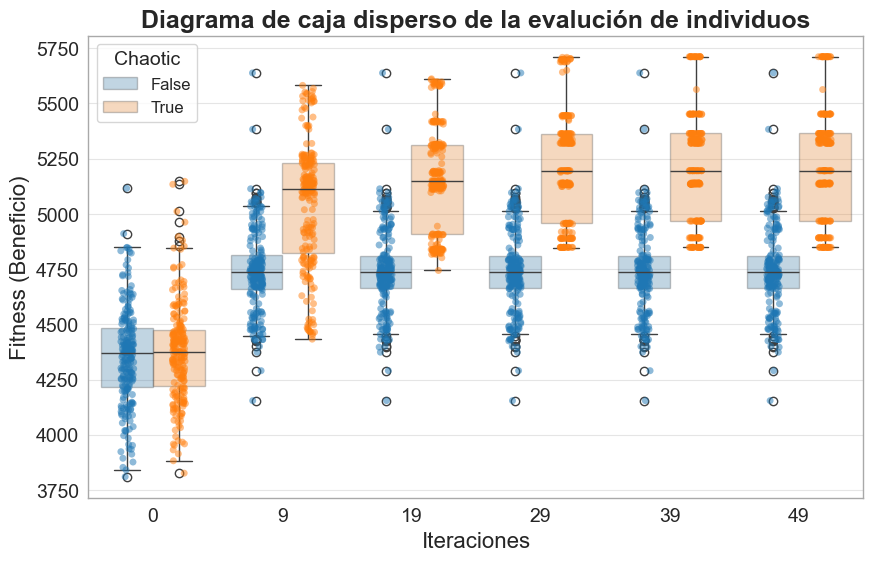

In [15]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 9, 19, 29, 39, 49])]

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Fitness',
             hue='Chaotic',
             title="Diagrama de caja disperso de la evalución de individuos",
             x_label="Iteraciones",
             y_label="Fitness (Beneficio)",
             save_path=Path('../reports/gsa/scattered_boxplot_75.pdf'))

In [16]:
df_gcc

,Run,Iteration,Fitness,Accuracy,ExecutionTime,Discrete,Real,chaotic_constant
0,1,0,4849.438082,0,0.443852,"[False, False, False, False, True, True, False...","[1069, 1118, 1149, 865, 964, 1039, 906, 827, 9...",True
1,1,1,4849.438082,0,1.842353,"[False, False, False, False, True, True, False...","[1069, 1118, 1149, 865, 964, 1039, 906, 827, 9...",True
2,1,2,4849.438082,0,3.137242,"[False, False, False, False, True, True, False...","[1069, 1118, 1149, 865, 964, 1039, 906, 827, 9...",True
3,1,3,4997.928999,0,4.527333,"[False, False, False, False, True, True, False...","[1063, 1112, 1146, 872, 975, 1049, 902, 826, 9...",True
4,1,4,4997.928999,0,6.036871,"[False, False, False, False, True, True, False...","[1063, 1112, 1146, 872, 975, 1049, 902, 826, 9...",True
...,...,...,...,...,...,...,...,...
45,11,45,5654.568577,0,55.850001,"[False, True, False, False, True, True, False,...","[1063, 1112, 1145, 873, 975, 1051, 905, 821, 9...",False
46,11,46,5654.568577,0,57.054369,"[False, True, False, False, True, True, False,...","[1063, 1112, 1145, 873, 975, 1051, 905, 821, 9...",False
47,11,47,5654.568577,0,58.257005,"[False, True, False, False, True, True, False,...","[1063, 1112, 1145, 873, 975, 1051, 905, 821, 9...",False
48,11,48,5654.568577,0,59.461422,"[False, True, False, False, True, True, False,...","[1063, 1112, 1145, 873, 975, 1051, 905, 821, 9...",False


In [17]:
# Table with results by run
service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += set(service_tsps.values())

summary_df = pd.DataFrame(columns=columns)

df_train_chaotic = df_gcc[df_gcc['chaotic_constant'] == True]
run_grouped_df = df_train_chaotic.groupby('Run')

for group in run_grouped_df.groups:
    run = run_grouped_df.get_group(group)['Run'].iloc[-1]
    revenue = run_grouped_df.get_group(group)['Fitness'].iloc[-1]
    execution_time = run_grouped_df.get_group(group)['ExecutionTime'].iloc[-1]
    scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
    scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
    real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
    sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
    delta_dt = 0.0
    delta_tt = 0.0
    services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
    for i, service in enumerate(sm.requested_schedule):
        if not scheduled_trains_array[i]:
            continue
        departure_station = list(sm.requested_schedule[service].keys())[0]
        delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                        sm.requested_schedule[service][departure_station][1])
        for j, stop in enumerate(sm.requested_schedule[service].keys()):
            if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                continue
            delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])

        service_tsp = service_tsps[service]
        services_by_tsp[service_tsp] += 1

    percentages_by_tsp = {}
    for tsp in services_by_tsp:
        percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100,2)} %"
    row_data =  [run, revenue, execution_time, scheduled_trains, delta_dt, delta_tt, *list(percentages_by_tsp.values())]
    summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),RU2,RU4,RU1,RU3
10,11,5717.519062,61.649768,25,42.0,157.0,23.08 %,48.28 %,38.89 %,6.67 %
5,6,5470.634665,62.116109,24,36.0,193.0,23.08 %,44.83 %,38.89 %,6.67 %
8,9,5395.108227,61.832477,23,51.0,187.0,23.08 %,41.38 %,33.33 %,13.33 %
9,10,5368.822721,61.960467,24,31.0,174.0,15.38 %,48.28 %,33.33 %,13.33 %
3,4,5335.687990,61.559602,24,52.0,198.0,23.08 %,41.38 %,38.89 %,13.33 %
1,2,5264.869587,62.812630,22,33.0,211.0,23.08 %,31.03 %,50.0 %,6.67 %
2,3,5195.533049,61.634582,22,38.0,194.0,23.08 %,31.03 %,50.0 %,6.67 %
6,7,5162.509907,62.004045,22,44.0,200.0,23.08 %,34.48 %,38.89 %,13.33 %
0,1,4997.928999,65.048749,21,36.0,230.0,23.08 %,31.03 %,44.44 %,6.67 %
7,8,4959.612366,62.217115,21,28.0,177.0,15.38 %,31.03 %,50.0 %,6.67 %


In [18]:
summary_df.to_latex()

'\\begin{tabular}{lrrrrrrllll}\n\\toprule\n & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU2 & RU4 & RU1 & RU3 \\\\\n\\midrule\n10 & 11 & 5717.519062 & 61.649768 & 25 & 42.000000 & 157.000000 & 23.08 % & 48.28 % & 38.89 % & 6.67 % \\\\\n5 & 6 & 5470.634665 & 62.116109 & 24 & 36.000000 & 193.000000 & 23.08 % & 44.83 % & 38.89 % & 6.67 % \\\\\n8 & 9 & 5395.108227 & 61.832477 & 23 & 51.000000 & 187.000000 & 23.08 % & 41.38 % & 33.33 % & 13.33 % \\\\\n9 & 10 & 5368.822721 & 61.960467 & 24 & 31.000000 & 174.000000 & 15.38 % & 48.28 % & 33.33 % & 13.33 % \\\\\n3 & 4 & 5335.687990 & 61.559602 & 24 & 52.000000 & 198.000000 & 23.08 % & 41.38 % & 38.89 % & 13.33 % \\\\\n1 & 2 & 5264.869587 & 62.812630 & 22 & 33.000000 & 211.000000 & 23.08 % & 31.03 % & 50.0 % & 6.67 % \\\\\n2 & 3 & 5195.533049 & 61.634582 & 22 & 38.000000 & 194.000000 & 23.08 % & 31.03 % & 50.0 % & 6.67 % \\\\\n6 & 7 & 5162.509907 & 62.004045 & 22 & 44.000000 & 200.000000 & 23.08

In [19]:
def get_gsa_table_results(chaotic: bool = True) -> pd.DataFrame:
    service_tsps = {service.id: service.tsp.name for service in supply.services}
    columns = ['Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
    columns += set(service_tsps.values())
    
    summary_df = pd.DataFrame(columns=columns)
    
    df_train_chaotic = df_gcc[df_gcc['chaotic_constant'] == chaotic]
    run_grouped_df = df_train_chaotic.groupby('Run')
    
    for group in run_grouped_df.groups:
        run = run_grouped_df.get_group(group)['Run'].iloc[-1]
        revenue = run_grouped_df.get_group(group)['Fitness'].iloc[-1]
        execution_time = run_grouped_df.get_group(group)['ExecutionTime'].iloc[-1]
        scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
        scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
        real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains))
        delta_dt = 0.0
        delta_tt = 0.0
        services_by_tsp = {tsp: 0 for tsp in service_tsps.values()}
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(sm.updated_schedule[service][departure_station][1] -
                            sm.requested_schedule[service][departure_station][1])
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(sm.updated_schedule[service][stop][1] - sm.requested_schedule[service][stop][1])
    
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1
    
        percentages_by_tsp = {}
        for tsp in services_by_tsp:
            percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100,2)} %"
        row_data =  [run, revenue, execution_time, scheduled_trains, delta_dt, delta_tt, *list(percentages_by_tsp.values())]
        summary_df.loc[len(summary_df)] = row_data
    
    return summary_df.sort_values('Revenue', ascending=False)

summary_df_nc = get_gsa_table_results(chaotic=False)
display(summary_df_nc)

,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),RU2,RU4,RU1,RU3
10,11,5654.568577,60.658455,24,46.0,181.0,23.08 %,44.83 %,38.89 %,6.67 %
8,9,5280.929864,60.877904,18,33.0,191.0,7.69 %,31.03 %,38.89 %,6.67 %
2,3,5263.822994,62.159722,20,54.0,204.0,23.08 %,27.59 %,44.44 %,6.67 %
9,10,5176.377966,60.789251,20,41.0,180.0,15.38 %,31.03 %,38.89 %,13.33 %
5,6,5064.689270,61.031369,21,36.0,212.0,23.08 %,31.03 %,44.44 %,6.67 %
3,4,5034.192197,61.357924,20,60.0,229.0,23.08 %,27.59 %,44.44 %,6.67 %
4,5,5016.337413,60.905836,20,32.0,204.0,23.08 %,27.59 %,44.44 %,6.67 %
6,7,5015.418947,60.928796,20,41.0,210.0,23.08 %,27.59 %,44.44 %,6.67 %
0,1,4974.533483,61.768617,20,23.0,220.0,23.08 %,27.59 %,44.44 %,6.67 %
1,2,4857.136227,62.059596,20,32.0,192.0,23.08 %,27.59 %,44.44 %,6.67 %


In [20]:
summary_df_nc.to_latex()

'\\begin{tabular}{lrrrrrrllll}\n\\toprule\n & Run & Revenue & Execution Time (s.) & Scheduled Trains & Delta DT (min.) & Delta TT (min.) & RU2 & RU4 & RU1 & RU3 \\\\\n\\midrule\n10 & 11 & 5654.568577 & 60.658455 & 24 & 46.000000 & 181.000000 & 23.08 % & 44.83 % & 38.89 % & 6.67 % \\\\\n8 & 9 & 5280.929864 & 60.877904 & 18 & 33.000000 & 191.000000 & 7.69 % & 31.03 % & 38.89 % & 6.67 % \\\\\n2 & 3 & 5263.822994 & 62.159722 & 20 & 54.000000 & 204.000000 & 23.08 % & 27.59 % & 44.44 % & 6.67 % \\\\\n9 & 10 & 5176.377966 & 60.789251 & 20 & 41.000000 & 180.000000 & 15.38 % & 31.03 % & 38.89 % & 13.33 % \\\\\n5 & 6 & 5064.689270 & 61.031369 & 21 & 36.000000 & 212.000000 & 23.08 % & 31.03 % & 44.44 % & 6.67 % \\\\\n3 & 4 & 5034.192197 & 61.357924 & 20 & 60.000000 & 229.000000 & 23.08 % & 27.59 % & 44.44 % & 6.67 % \\\\\n4 & 5 & 5016.337413 & 60.905836 & 20 & 32.000000 & 204.000000 & 23.08 % & 27.59 % & 44.44 % & 6.67 % \\\\\n6 & 7 & 5015.418947 & 60.928796 & 20 & 41.000000 & 210.000000 & 23.08 

In [73]:
# Global status

def get_gsa_global_status(df: pd.DataFrame):
    run_grouped_df = df.groupby('Run')
    print("Global GSA status:")
    
    # Execution time (mean and std.)
    run_times = run_grouped_df['ExecutionTime'].last()
    print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
    print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
    
    # Revenue (mean and std.)
    run_revenues = run_grouped_df['Fitness'].last()
    print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
    
    # Scheduled trains (mean and std.)
    run_trains = run_grouped_df['Discrete'].last().apply(sum)
    print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
    
    runs_best_solution_history = dict(sorted(rbs_hist[True].items(),
                                             key=lambda x: x[1][1]))
    
    q2_solution_index = np.floor(runs // 2).astype(int)
    gsa_solution = tuple(runs_best_solution_history.items())[q2_solution_index]
    
    print(f"\tMedian solution: Run {gsa_solution[0]}")
    max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
    print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
    
    return gsa_solution

df_train_chaotic = df_gcc[df_gcc['chaotic_constant'] == True]
gsa_solution = get_gsa_global_status(df_train_chaotic)

Global GSA status:
	Total execution time: 684.3219 s.
	Execution Time (by run) - Mean: 62.2111 s. - Std: 1.0134 s.
	Revenue - Mean: 5247.0435 - Std: 250.795
	Scheduled Trains - Mean: 23.0 - Std: 2.0
	Median solution: Run 2
	Max Revenue: 17157.25 - WARNING!: Scheduling all services could not be feasible


In [74]:
df_train_nc = df_gcc[df_gcc['chaotic_constant'] == False]
_ = get_gsa_global_status(df_train_nc)

Global GSA status:
	Total execution time: 673.2244 s.
	Execution Time (by run) - Mean: 61.2022 s. - Std: 0.5501 s.
	Revenue - Mean: 5104.349 - Std: 234.8187
	Scheduled Trains - Mean: 20.0 - Std: 1.0
	Median solution: Run 2
	Max Revenue: 17157.25 - WARNING!: Scheduling all services could not be feasible


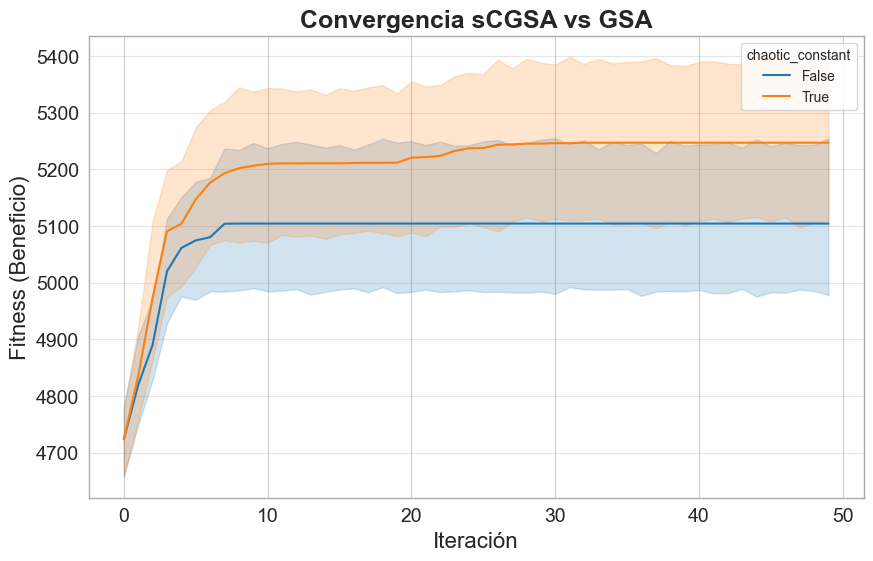

In [27]:
# GSA Convergence plot
sns_line_plot(df=df_gcc,
              x_data="Iteration",
              y_data="Fitness",
              hue="chaotic_constant",
              title="Convergencia sCGSA vs GSA",
              x_label="Iteración",
              y_label="Fitness (Beneficio)",
              save_path=Path('../reports/gsa/gsa_convergence_75.pdf'))

In [28]:
from scipy import stats

fitness_sCGSA = summary_df['Revenue'].values
fitness_GSA = summary_df_nc['Revenue'].values

fitness_sCGSA, fitness_GSA

(array([5717.51906184, 5470.63466526, 5395.10822689, 5368.82272128,
        5335.6879904 , 5264.86958685, 5195.53304876, 5162.50990688,
        4997.92899888, 4959.61236643, 4849.25170497]),
 array([5654.56857743, 5280.92986364, 5263.82299424, 5176.37796605,
        5064.68926985, 5034.19219719, 5016.33741263, 5015.41894656,
        4974.53348327, 4857.13622731, 4809.8326044 ]))

In [29]:
stat, p_value = stats.wilcoxon(fitness_sCGSA, fitness_GSA)
print(f"Estadístico de Wilcoxon: {stat}, Valor p: {p_value}")

Estadístico de Wilcoxon: 0.0, Valor p: 0.0009765625


In [30]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behaviour=revenue_behaviour,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=gsa_solution[1][0])

sm.update_schedule(solution=gsa_solution[1][0])

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if gsa_solution[1][0].discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

#plotter = TrainSchedulePlotter(filtered_services, line)
#plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
print(supply_save_path, tt_file_name)
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)

# Copy previous file in reports
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'gsa/{tt_file_name}_75.yml')

supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

../configs/gsa_results/ supply_config_gsa


In [31]:
final_supply = Supply.from_yaml(supply_config_file)

{'4_2024-06-25-22.34': {'Madrid': [1356.0, 1356.0], 'Barcelona': [1524.0, 1524.0]}, '5_2024-06-25-12.09': {'Lleida': [731.0, 731.0], 'Barcelona': [802.0, 802.0]}, '13_2024-06-25-15.39': {'Madrid': [940.0, 940.0], 'Guadalajara': [968.0, 975.0], 'Zaragoza': [1044.0, 1047.0], 'Lleida': [1101.0, 1103.0], 'Tarragona': [1139.0, 1141.0], 'Barcelona': [1187.0, 1187.0]}, '15_2024-06-25-6.52': {'Zaragoza': [410.0, 410.0], 'Lleida': [461.0, 467.0], 'Tarragona': [500.0, 504.0], 'Barcelona': [547.0, 547.0]}, '21_2024-06-25-20.41': {'Madrid': [1248.0, 1248.0], 'Barcelona': [1447.0, 1447.0]}, '26_2024-06-25-3.37': {'Lleida': [219.0, 219.0], 'Barcelona': [296.0, 296.0]}, '33_2024-06-25-12.36': {'Madrid': [756.0, 756.0], 'Guadalajara': [786.0, 788.0], 'Calatayud': [843.0, 849.0], 'Zaragoza': [881.0, 883.0], 'Lleida': [942.0, 946.0], 'Tarragona': [984.0, 986.0], 'Barcelona': [1036.0, 1036.0]}, '35_2024-06-25-18.18': {'Zaragoza': [1099.0, 1099.0], 'Lleida': [1147.0, 1151.0], 'Tarragona': [1182.0, 1185.0]

/Users/david/PycharmProjects/GSA_M/venv/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


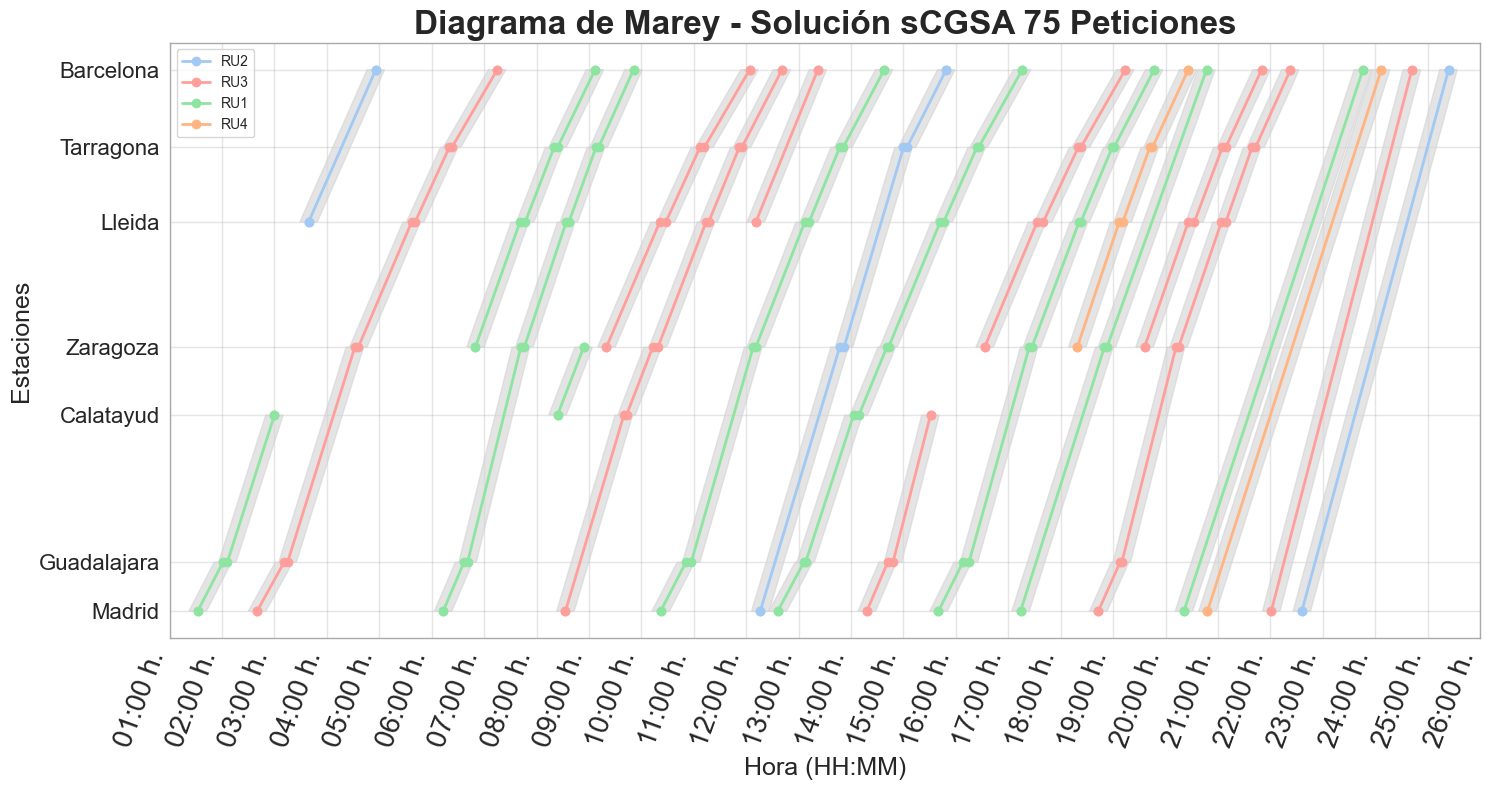

In [32]:
plot_marey_chart(requested_supply=final_supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey - Solución sCGSA 75 Peticiones",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/gsa/marey_chart_sol_75.pdf'))

In [33]:
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'gsa/{tt_file_name}_75.yml')

PosixPath('../reports/gsa/supply_config_gsa_75.yml')

In [34]:
#!snakeviz profile.pstat

In [35]:
# Simulate market
kernel = Kernel(path_config_supply=supply_config_file,
                path_config_demand=demand_config_path,
                seed=21)

services = kernel.simulate(output_path=Path(f'{robin_save_path}output.csv'),
                           save_trace=True,
                           departure_time_hard_restriction=True)

kernel_plotter = KernelPlotter(path_output_csv=Path(f'{robin_save_path}output.csv'),
                               path_config_supply=supply_config_file)

kernel_plotter.plotter_data_analysis()

Data from demand plot: 
	Status: Encontraron algún billete útil, pero no pudieron comprar. - Passengers: 5130
	Status: Compraron un billete diferente al de mayor utilidad. - Passengers: 2482
	Status: Compraron el billete con mayor utilidad. - Passengers: 1320
	Status: No encontraron ningún billete útil. - Passengers: 0

Data from pie chart: 
	Total tickets sold:  3802
	Percentage of tickets sold by seat type: 
		Seat: Premium - Passengers: 298 - Percentage: 7.84 %
		Seat: Turista - Passengers: 2918 - Percentage: 76.75 %
		Seat: TuristaPlus - Passengers: 586 - Percentage: 15.41 %

Data from plot tickets sold by purchase day: 
	Total tickets sold:  3802
	Tickets sold by purchase date and seat type: 
		Date: 2024-06-11
			Seat: Premium - Number of tickets sold: 56
			Seat: Turista - Number of tickets sold: 220
			Seat: TuristaPlus - Number of tickets sold: 172
		Date: 2024-06-12
			Seat: Premium - Number of tickets sold: 2
			Seat: Turista - Number of tickets sold: 203
			Seat: TuristaPlu

In [36]:
shutil.copyfile(f'{robin_save_path}output.csv', f'../reports/robin/output_75.csv')

'../reports/robin/output_75.csv'

In [65]:
# Open output csv
output_df = pd.read_csv(f'{robin_save_path}output.csv')

In [69]:
df = output_df.copy()
df['route'] = df['departure_station'] + '-' + df['arrival_station']

df = df.dropna(subset=['service'])

# Agrupar por 'user_pattern' y 'route', y contar el número de ocurrencias
grouped = df.groupby(['user_pattern', 'route']).size().reset_index(name='passengers')

# Crear el diccionario final
passenger_dict = {}
for _, row in grouped.iterrows():
    user_pattern = row['user_pattern']
    route = row['route']
    passengers = row['passengers']
    
    if user_pattern not in passenger_dict:
        passenger_dict[user_pattern] = {}
    
    passenger_dict[user_pattern][route] = passengers

In [70]:
# Convertir el diccionario en un DataFrame
df = pd.DataFrame(passenger_dict).T

# Calcular el número total de pasajeros para cada tipo (user_pattern)
df['Total Pasajeros'] = df.sum(axis=1)

# Calcular el número total de pasajeros en general
total_passengers = df['Total Pasajeros'].sum()

# Añadir una fila para el total general
df.loc['Total General'] = df.sum(axis=0)
df.at['Total General', 'Total Pasajeros'] = total_passengers

In [72]:
df

,Madrid-Barcelona,Madrid-Zaragoza,Zaragoza-Barcelona,Total Pasajeros
Aventurero,52.0,30.0,45.0,127.0
Business,322.0,67.0,48.0,437.0
Estudiante,NaN,39.0,309.0,348.0
Turista,1813.0,227.0,222.0,2262.0
Turista de Eventos,500.0,74.0,54.0,628.0
Total General,2687.0,437.0,678.0,3802.0


In [71]:
df.to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n & Madrid-Barcelona & Madrid-Zaragoza & Zaragoza-Barcelona & Total Pasajeros \\\\\n\\midrule\nAventurero & 52.000000 & 30.000000 & 45.000000 & 127.000000 \\\\\nBusiness & 322.000000 & 67.000000 & 48.000000 & 437.000000 \\\\\nEstudiante & NaN & 39.000000 & 309.000000 & 348.000000 \\\\\nTurista & 1813.000000 & 227.000000 & 222.000000 & 2262.000000 \\\\\nTurista de Eventos & 500.000000 & 74.000000 & 54.000000 & 628.000000 \\\\\nTotal General & 2687.000000 & 437.000000 & 678.000000 & 3802.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

{'Turista': {'TuristaPlus': 397, 'Turista': 1865}, 'Turista de Eventos': {'Turista': 548, 'Premium': 80}, 'Aventurero': {'Turista': 30, 'Premium': 92, 'TuristaPlus': 5}, 'Business': {'Premium': 126, 'Turista': 311}, 'Estudiante': {'Turista': 164, 'TuristaPlus': 184}}


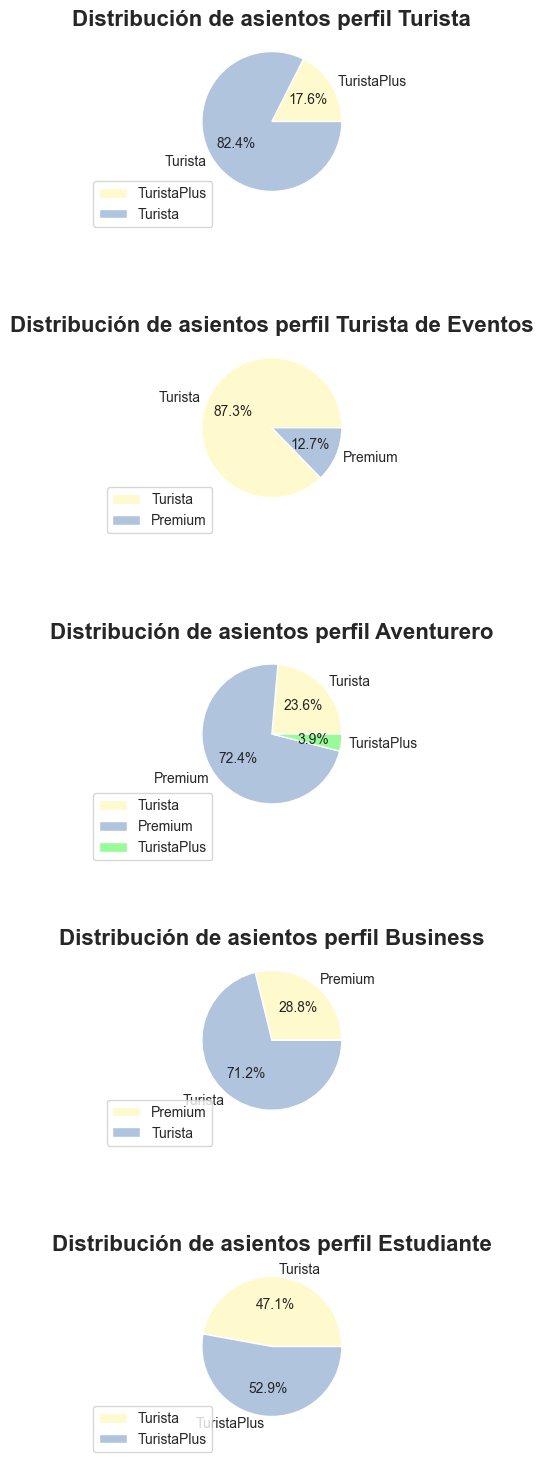

In [42]:
kernel_plotter.plot_users_seat_pie_chart(save_path='../reports/robin/users_seat_pie_chart_75.pdf')

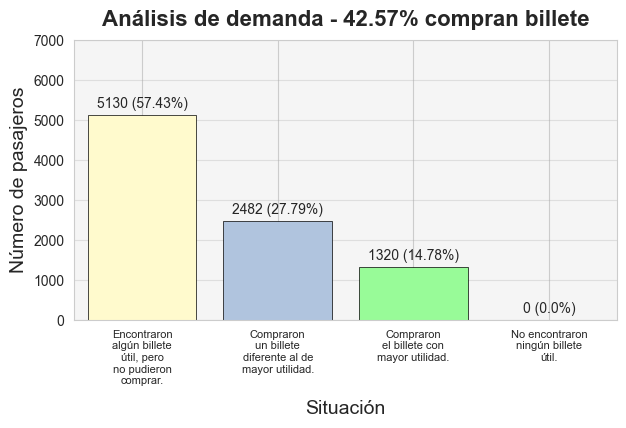

In [43]:
kernel_plotter.plot_demand_status(y_limit=7000, save_path='../reports/robin/demand_status_75.pdf')

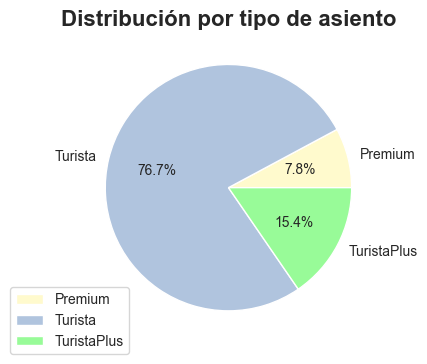

In [44]:
kernel_plotter.plot_seat_distribution_pie_chart(save_path='../reports/robin/seat_distribution_pie_chart_75.pdf')

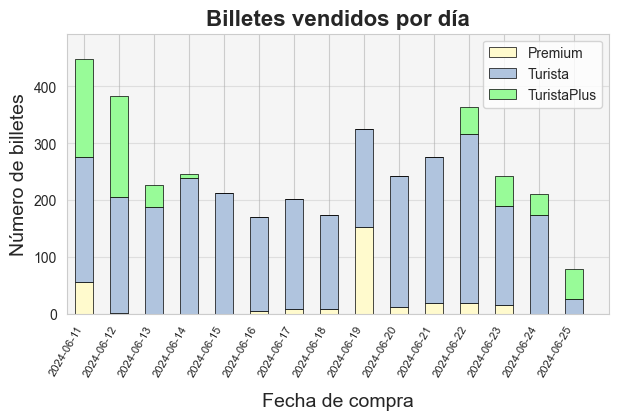

In [45]:
kernel_plotter.plot_tickets_by_date(save_path='../reports/robin/tickets_by_date_75.pdf')

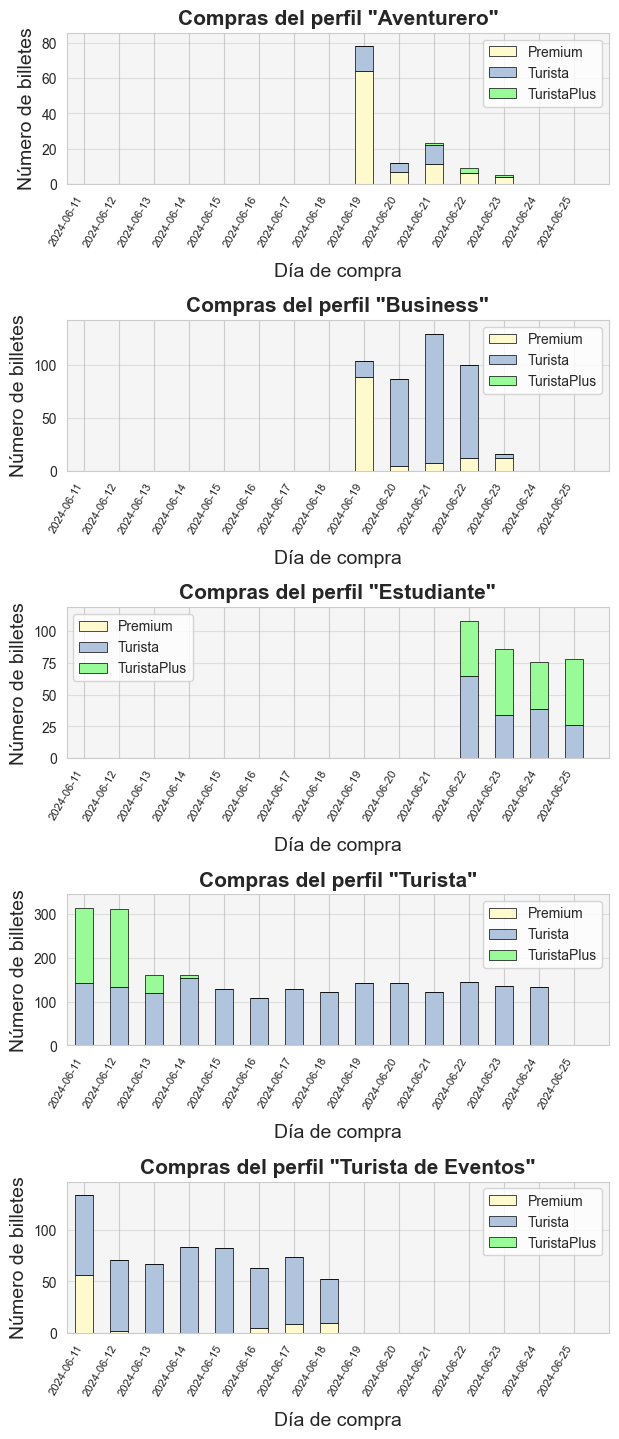

In [46]:
kernel_plotter.plot_tickets_by_user(save_path='../reports/robin/tickets_by_user_75.pdf')

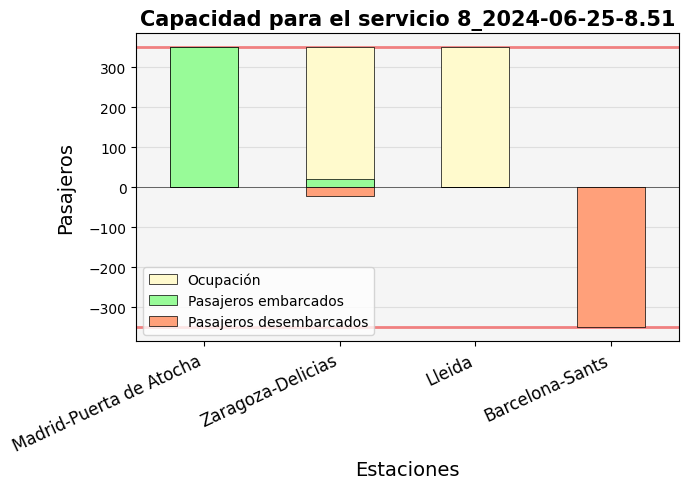

In [40]:
kernel_plotter.plot_service_capacity(service_id='8_2024-06-25-8.51',
                                     save_path='../reports/robin/service_capacity_8_2024-06-25-8.51_50.pdf')

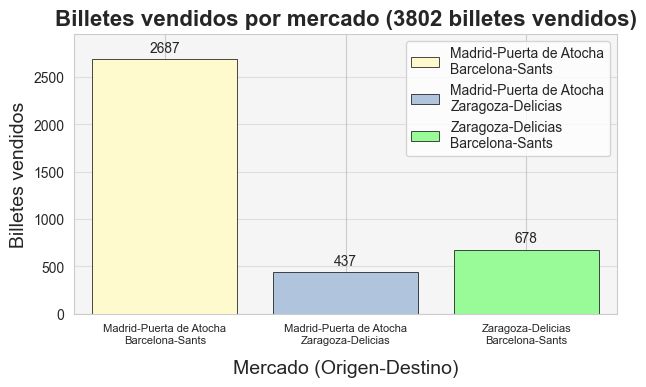

In [47]:
kernel_plotter.plot_tickets_by_pair(save_path='../reports/robin/tickets_by_pair_75.pdf')

## Load inference trace

In [48]:
trace_path = Path(f'{robin_save_path}/inference_trace.json')

# Load trace json
with open(trace_path, 'r') as f:
    trace = json.load(f)

In [49]:
# Copy trace file in reports
shutil.copyfile(trace_path, reports_path / 'inference_trace_75.json')

PosixPath('../reports/inference_trace_75.json')

In [50]:
# Tickets bought by user pattern

n_pass = {}
for t in trace:
   if trace[t]['user_pattern'] not in n_pass:
       n_pass[trace[t]['user_pattern']] = 1
   else:
       n_pass[trace[t]['user_pattern']] += 1

n_pass

{'Turista': 2262,
 'Turista de Eventos': 628,
 'Aventurero': 127,
 'Business': 437,
 'Estudiante': 348}

## Load user patterns and variables from demand config file

In [51]:
# Load demand config yaml
with open(demand_config_path, 'r') as f:
    demand_config = yaml.safe_load(f)

In [52]:
user_patterns = []
variables = {}
rules = {}

for user_pattern in demand_config['userPattern']:
    user_patterns.append(user_pattern['name'])
    for variable in user_pattern['variables']:
        if variable['name'] not in variables:
            if variable['type'] == 'fuzzy':
                variables[variable['name']] = variable['sets']
            elif variable['type'] == 'categorical':
                variables[variable['name']] = variable['labels']
        else:
            # Assert set matches
            if variable['type'] == 'fuzzy':
                assert variables[variable['name']] == variable['sets']
            elif variable['type'] == 'categorical':
                assert variables[variable['name']] == variable['labels']
                
    rules[user_pattern['name']] = [rule for rule in user_pattern['rules']]
                
print(user_patterns)
pprint.pp(variables)
pprint.pp(rules)

['Business', 'Estudiante', 'Turista', 'Turista de Eventos', 'Aventurero']
{'origin': ['very_near', 'mid_range', 'far', 'far_away'],
 'destination': ['very_near', 'mid_range', 'far', 'far_away'],
 'departure_time': ['in_time', 'close', 'remote', 'very_remote'],
 'arrival_time': ['in_time', 'close', 'remote', 'very_remote'],
 'price': ['very_cheap', 'cheap', 'medium', 'expensive'],
 'seat': ['Turista', 'TuristaPlus', 'Premium'],
 'tsp': ['RU1', 'RU2', 'RU3', 'RU4']}
{'Business': ['R0', 'R1', 'R2'],
 'Estudiante': ['R0', 'R1', 'R2', 'R3'],
 'Turista': ['R0', 'R1', 'R2', 'R3'],
 'Turista de Eventos': ['R0', 'R1', 'R2'],
 'Aventurero': ['R0', 'R1', 'R2']}


In [59]:
# Create dataframes for each behaviour variable

behaviour_dfs = {}
for variable in variables:
    behaviour_dfs[variable] = pd.DataFrame(columns=user_patterns, index=variables[variable])
    
    for variable_set in variables[variable]:
        behaviour_dfs[variable].loc[variable_set] = [np.zeros(3) for _ in range(len(user_patterns))]

In [60]:
def update_behaviour_dfs(behaviour_dfs: Mapping[str, pd.DataFrame],
                         user_pattern: str,
                         rules: List):
    passenger_set = set()
    def recurse_elements(element):
        if isinstance(element, dict):
            if 'variable' in element:
                if element['variable'] in behaviour_dfs:
                    set_name_and_values = element['setname_and_values']
                    set_name = set_name_and_values[0] if type(set_name_and_values) is list else set_name_and_values
                    if set_name in behaviour_dfs[element['variable']].index:
                        behaviour_dfs[element['variable']].loc[set_name, user_pattern][0] += element['result']
                        behaviour_dfs[element['variable']].loc[set_name, user_pattern][1] += 1
                        if (element['variable'], set_name) not in passenger_set:
                            behaviour_dfs[element['variable']].loc[set_name, user_pattern][2] += 1
                            passenger_set.add((element['variable'], set_name))
            for value in element.values():
                recurse_elements(value)
        elif isinstance(element, list):
            for item in element:
                recurse_elements(item)

    for rule in rules:
        recurse_elements(rule)

    return behaviour_dfs

for passenger in trace:
    user_pattern = trace[passenger]['user_pattern']
    behaviour_dfs = update_behaviour_dfs(behaviour_dfs=behaviour_dfs,
                                         user_pattern=user_pattern,
                                         rules=trace[passenger]['trace_of_each_rule'])

In [61]:
# Multicolumn pandas dataframes

for df in behaviour_dfs: 
    values = behaviour_dfs[df].values
    np_vals = np.array([val for row in values for data in row for val in data], dtype=np.float32)
    np_vals = np_vals.reshape(len(behaviour_dfs[df].index), 3 * len(user_patterns))
    
    midx = pd.MultiIndex.from_product([user_patterns, ['Sum', 'Count', 'Passengers']])
    multicol_df = pd.DataFrame(np_vals, index=behaviour_dfs[df].index, columns=midx)
    print(f'Variable: {df}')
    print(multicol_df)

Variable: origin
          Business                   Estudiante                   Turista  \
               Sum  Count Passengers        Sum  Count Passengers     Sum   
very_near    437.0  437.0      437.0      696.0  696.0      348.0  2262.0   
mid_range      0.0    0.0        0.0        0.0    0.0        0.0     0.0   
far            0.0    0.0        0.0        0.0    0.0        0.0     0.0   
far_away       0.0    0.0        0.0        0.0    0.0        0.0     0.0   

                             Turista de Eventos                   Aventurero  \
            Count Passengers                Sum  Count Passengers        Sum   
very_near  2262.0     2262.0              628.0  628.0      628.0      127.0   
mid_range  2262.0     2262.0                0.0    0.0        0.0        0.0   
far           0.0        0.0                0.0    0.0        0.0        0.0   
far_away      0.0        0.0                0.0    0.0        0.0        0.0   

                             
         

In [62]:
rules_dfs = {}
columns = ['Consequent', 'Percentage']
for user_type in rules:
    rules_dfs[user_type] = pd.DataFrame(columns=rules[user_type], index=np.array(columns))
    
    # Fill dataframe with zeros
    for rule in rules[user_type]:
        for col in columns:
            rules_dfs[user_type].loc[col, rule] = np.float32(0.0)

In [63]:
def update_rules_dfs(rules_dfs: Mapping[str, pd.DataFrame],
                     user_pattern: str,
                     rules: List):
   
    for rule in rules:
        rules_dfs[user_pattern].loc['Consequent', rule['name']] += rule['result']

    return rules_dfs

for passenger in trace:
    user_pattern = trace[passenger]['user_pattern']
    behaviour_dfs = update_rules_dfs(rules_dfs=rules_dfs,
                                     user_pattern=user_pattern,
                                     rules=trace[passenger]['trace_of_each_rule'])
    
# Round cells of dataframe to 2 decimals
for user_type in rules_dfs:
    rules_dfs[user_type] = rules_dfs[user_type].round(2)
    
    # Sum of values in 'Consequent' row
    sum_consequents = 0.0
    for col in rules_dfs[user_type].columns:
        sum_consequents += rules_dfs[user_type].loc['Consequent', col]
        
    # Update 'Percentage' row
    for col in rules_dfs[user_type].columns:
        rules_dfs[user_type].loc['Percentage', col] = f"{np.round(rules_dfs[user_type].loc['Consequent', col] / sum_consequents * 100, 2)} %"

for user_type in rules_dfs:
    print(f'User: {user_type}')
    #display(rules_dfs[user_type])
    print(rules_dfs[user_type])

User: Business
                 R0       R1        R2
Consequent  2519.43  1506.81  26304.27
Percentage   8.31 %   4.97 %   86.73 %
User: Estudiante
                 R0       R1           R2        R3
Consequent  3576.24  6959.28  3111.610967  20774.09
Percentage  10.39 %  20.22 %       9.04 %   60.35 %
User: Turista
                 R0        R1        R2        R3
Consequent  20297.5  22662.13  42740.86  113039.8
Percentage  10.21 %    11.4 %   21.51 %   56.88 %
User: Turista de Eventos
                    R0            R1       R2
Consequent  15575.7594  29063.136533  15735.4
Percentage      25.8 %       48.14 %  26.06 %
User: Aventurero
                    R0       R1      R2
Consequent  6008.20364  4474.01    67.1
Percentage     56.95 %  42.41 %  0.64 %
